In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/Convolutional_Model/Transfer_Learning")

In [3]:
!ls

agilas4.jpg  butterfly13.jpg  cat.jpg  datasets  transfer_learning.ipynb


En los ejemplos realizados en este cuaderno se utilizaran modelos preentrenados. Estos modelos y las herramenitas para modificarlos se encuentran en las librerias TENSORNETS creadas por Taehoon Lee. Estas se pueden encontrar en el repositorio:
https://github.com/taehoonlee/tensornets
para instalar estas librerias se requiere cython por lo que se instalan los dos en la siguiente celda

In [4]:
!pip install cython
!pip install tensornets

    100% |████████████████████████████████| 2.1MB 6.6MB/s 
    100% |████████████████████████████████| 593kB 7.1MB/s 
  Running setup.py bdist_wheel for tensornets ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/12/56/86/d29c1f3743caf453be8f1b9615f170a12d22e8bbf200c19a36
Successfully built tensornets


En el siguiente ejemplo se muestra como cargar una arquitectura pre-entrenada para usarla con un dato nuevo.

In [5]:
import tensorflow as tf
import tensornets as nets

inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])
model = nets.ResNet50(inputs)
assert isinstance(model, tf.Tensor)

img = nets.utils.load_img('butterfly13.jpg', target_size=256, crop_size=224)
assert img.shape == (1, 224, 224, 3)

with tf.Session() as sess:
    img = model.preprocess(img)  # equivalent to img = nets.preprocess(model, img)
    sess.run(model.pretrained())  # equivalent to nets.pretrained(model)
    preds = sess.run(model, {inputs: img})

print(nets.utils.decode_predictions(preds, top=2)[0])

40960/35363 [==================================] - 0s 1us/step
[('n03476684', 'hair_slide', 0.4574956), ('n02279972', 'monarch', 0.19639634)]


Otro ejemplo con una arquitectura diferente. en este caso para la detección de objetos, que devuelve  la region de la imágen donde esta se encuentra el objeto buscado.

202727424/202721023 [==============================] - 15s 0us/step
cat: [ 56.           9.         148.         132.           0.41352683]


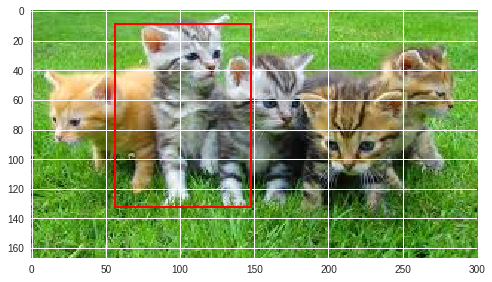

In [6]:
import tensorflow as tf
import tensornets as nets

inputs = tf.placeholder(tf.float32, [None, 416, 416, 3])
model = nets.YOLOv2(inputs, nets.Darknet19)

img = nets.utils.load_img('cat.jpg')

with tf.Session() as sess:
    sess.run(model.pretrained())
    preds = sess.run(model, {inputs: model.preprocess(img)})
    boxes = model.get_boxes(preds, img.shape[1:3])
    
from tensornets.datasets import voc
print("%s: %s" % (voc.classnames[7], boxes[7][0]))  # 7 is cat

import numpy as np
import matplotlib.pyplot as plt
box = boxes[7][0]
plt.imshow(img[0].astype(np.uint8))
plt.gca().add_patch(plt.Rectangle(
    (box[0], box[1]), box[2] - box[0], box[3] - box[1],
    fill=False, edgecolor='r', linewidth=2))
plt.show()

Pero si lo que queremos es usar una salida intermedia de la arquitectura preentrenada para entrenar el resto con nuestros datos seguimos el siguiente procedimiento usando las funciones  get_middles() y get_outputs():

In [7]:
import tensorflow as tf
import tensornets as nets

inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])
model = nets.ResNet50(inputs)
assert isinstance(model, tf.Tensor)

img = nets.utils.load_img('agilas4.jpg', target_size=256, crop_size=224)
assert img.shape == (1, 224, 224, 3)

with tf.Session() as sess:
    img = model.preprocess(img)
    sess.run(model.pretrained())
    middles = sess.run(model.get_middles(), {inputs: img})
    outputs = sess.run(model.get_outputs(), {inputs: img})
    
model.print_summary()

model.print_middles()
assert middles[0].shape == (1, 56, 56, 256)
assert middles[-1].shape == (1, 7, 7, 2048)

model.print_outputs()
#assert sum(sum((outputs[-1] - preds) ** 2)) < 1e-8

Scope: resnet50_1
Total layers: 54
Total weights: 320
Total parameters: 25,636,712
Scope: resnet50_1
conv2/block1/out:0 (?, 56, 56, 256)
conv2/block2/out:0 (?, 56, 56, 256)
conv2/block3/out:0 (?, 56, 56, 256)
conv3/block1/out:0 (?, 28, 28, 512)
conv3/block2/out:0 (?, 28, 28, 512)
conv3/block3/out:0 (?, 28, 28, 512)
conv3/block4/out:0 (?, 28, 28, 512)
conv4/block1/out:0 (?, 14, 14, 1024)
conv4/block2/out:0 (?, 14, 14, 1024)
conv4/block3/out:0 (?, 14, 14, 1024)
conv4/block4/out:0 (?, 14, 14, 1024)
conv4/block5/out:0 (?, 14, 14, 1024)
conv4/block6/out:0 (?, 14, 14, 1024)
conv5/block1/out:0 (?, 7, 7, 2048)
conv5/block2/out:0 (?, 7, 7, 2048)
conv5/block3/out:0 (?, 7, 7, 2048)
Scope: resnet50_1
conv1/pad:0 (?, 230, 230, 3)
conv1/conv/BiasAdd:0 (?, 112, 112, 64)
conv1/bn/FusedBatchNorm:0 (?, 112, 112, 64)
conv1/relu:0 (?, 112, 112, 64)
pool1/pad:0 (?, 114, 114, 64)
pool1/MaxPool:0 (?, 56, 56, 64)
conv2/block1/0/conv/BiasAdd:0 (?, 56, 56, 256)
conv2/block1/0/bn/FusedBatchNorm:0 (?, 56, 56, 256

los valores almacenados en middles o en outputs, son salidas en capas intermedias de la arquitectura, y estas salidas se pueden usar como entradas para capas definidas por nosotros. Estas capas puede ser solo el MLP o Full conected al final de la arquitectura...

In [0]:
import h5py
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensornets as nets

# Parámetros para el entrenamiento
training_epochs=10
batch_size=10  
learning_rate = 0.001
display_step=1

# Parametros de la red neuronal
n_hidden_1 = 1024 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 2048 # data input (feature shape ?,7,7,2048)
n_classes = 6 # total classes (6 signs)

X = tf.placeholder(tf.float32, [None, 224, 224, 3])
X2 = tf.placeholder(tf.float32, [None, 7, 7, 2048])
Y = tf.placeholder("float", [None, n_classes])

# Para cargar el modelo con la libreria tensornets
model = nets.ResNet50(X)
assert isinstance(model, tf.Tensor)

['list_classes', 'train_set_x', 'train_set_y']
(1080, 64, 64, 3)
(1080,)
['list_classes', 'test_set_x', 'test_set_y']
(120, 64, 64, 3)
(120,)
(1080, 224, 224, 3)
(120, 224, 224, 3)
(1080, 6)
(120, 6)


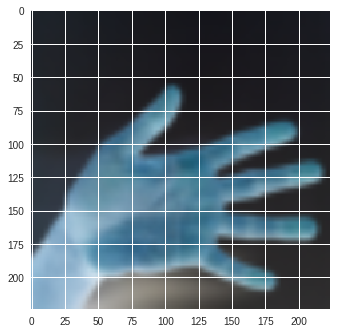

In [9]:
# Leer de una base de datos H5
with h5py.File('datasets/train_signs.h5','r') as h5data:
    ls=list(h5data.keys())
    print(ls)
    train_data=np.array(h5data.get('train_set_x')[:])
    train_labels=np.array(h5data.get('train_set_y')[:])
print(train_data.shape)    
print(train_labels.shape) 

with h5py.File('datasets/test_signs.h5','r') as h5data:
    ls=list(h5data.keys())
    print(ls)    
    test_data=np.array(h5data.get('test_set_x')[:])
    test_labels=np.array(h5data.get('test_set_y')[:])
print(test_data.shape)    
print(test_labels.shape)  

# Funcion para cambiar de tamaño las imágenes para adpatarlas a la arquitectura
def resize_np (np_array):
    resized=[]
    for i in list(np_array):
        larger=cv2.resize(i,(224,224))
        resized.append(np.array(larger))
    return (np.array(resized).astype(np.float32))

# Funcion para cambiar labels a onehot
def one_hot_transformation(labels,n_classes):
    samples=labels.size
    one_hot_labels=np.zeros((samples,n_classes))
    for i in range(samples):
        one_hot_labels[i,labels[i]]=1
    return(one_hot_labels)

X_train=resize_np(train_data)
print(X_train.shape)
X_test=resize_np(test_data)
print(X_test.shape)
Y_train=one_hot_transformation(train_labels,n_classes)
print(Y_train.shape)
Y_test=one_hot_transformation(test_labels,n_classes)
print(Y_test.shape)

# mostrar un ejemplo
plt.imshow(X_train[0])

In [0]:
# Declaración de los pesos y los bias (weight & bias)
weights = {'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],stddev=0.1)),
           'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],stddev=0.1)),
           'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes],stddev=0.1))
          }
biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1],stddev=0.1)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2],stddev=0.1)),
          'out': tf.Variable(tf.truncated_normal([n_classes],stddev=0.1))
         }

# Definición del perceptrón multicapa
def multilayer_perceptron(x):
    pool = tf.nn.avg_pool(x, ksize=[1, 7, 7, 1], strides=[1, 1, 1, 1], padding='VALID')
    flat=tf.layers.flatten(pool)
    layer_1 = tf.add(tf.matmul(flat, weights['h1']), biases['b1']) # Hidden fully connected layer with 256 neurons
    relu_1=tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(relu_1, weights['h2']), biases['b2']) # Hidden fully connected layer with 256 neurons
    relu_2=tf.nn.relu(layer_2)
    out_layer = tf.matmul(relu_2, weights['out']) + biases['out'] # Output fully connected layer with a neuron for each class
    return out_layer
# Declarar la operación que aplica el MLP usando la información de entrada
logits = multilayer_perceptron(X2)
# Declarar las operaciónes que establecen la funcion de perdida y optimización 
# para el entrenamiento.
loss_op = tf.losses.softmax_cross_entropy(
    onehot_labels=Y,
    logits=logits,
    weights=1.0,
    scope=None,
    loss_collection=tf.GraphKeys.LOSSES,
    reduction=tf.losses.Reduction.SUM_BY_NONZERO_WEIGHTS
)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

In [11]:
with tf.Session() as sess:
    sess.run(init)
    sess.run(model.pretrained())  # equivalent to nets.pretrained(model)
    for epoch in range(training_epochs):
        avg_cost = 0.
        #obtiene el numero de grupos en que queda dividida la base de datos
        total_batch = int(Y_train.shape[0]/batch_size) 
        # ciclo para entrenar con cada grupo de datos
        losses=[]
        for i in range(total_batch-1):
            batch_x= X_train[i*batch_size:(i+1)*batch_size]
            batch_y= Y_train[i*batch_size:(i+1)*batch_size]
            features = model.preprocess(batch_x)
            features = sess.run(model.get_middles(), {X: batch_x})[-1]
            
            # Correr la funcion de perdida y la operacion de optimización 
            # con la respectiva alimentación del placeholder
            _,c =sess.run([train_op, loss_op],feed_dict={X2:features,Y:batch_y})
            # Promedio de resultados de la funcion de pérdida
            losses.append(c)
            avg_cost += c / total_batch
        # Mostrar el resultado del entrenamiento por grupos
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

Epoch: 0001 cost=1.476565356
Epoch: 0002 cost=0.137877341
Epoch: 0003 cost=0.062184946
Epoch: 0004 cost=0.035096522
Epoch: 0005 cost=0.011922717
Epoch: 0006 cost=0.058923598
Epoch: 0007 cost=0.019855724
Epoch: 0008 cost=0.003021415
Epoch: 0009 cost=0.000441959
Epoch: 0010 cost=0.000162664
Optimization Finished!
